In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model

#prepped data is data that has dropped all cols and rows that do not matter
#scaled data is data that is scaled/normalized
#organized data is data that will be fed into the model

#number of points that dictates the number of days we will be basing our predicitons off of.
points = 50
ema_days = [12,26,50]
sma_days = [12,26,50]

In [2]:
def data_slicing(data_file):
    if data_file == None:
        print("Please enter a data file path and try again")
    else:
        data = pd.read_excel(data_file)
        
    
    cols_to_drop = ['Names Date','vars','days','smoothing','smoothing-1']   
    for col in cols_to_drop:
        data = data.drop(col,axis=1)
    #always drop the first 50 index so that all columns have values
    ind_to_drop = 50

    for i in range(ind_to_drop):
        data = data.drop(i)

    data = data.reset_index()
    data = data.drop('index', axis=1)
    
    columns = data.columns
    for col in columns:
        value = data[col].isnull().values.any()
        if value == True:
            index_null = data[data[col].isnull()].index.tolist()
            data = data.drop(index_null)

    if len(data) %2 != 0:
        data = data.drop(0)
        
    data = data.reset_index()
    data = data.drop('index', axis=1)
    
    if len(data) %50 != 0:
        i = len(data)
        while(i%50 != 0):
            i = i-1
            
    for j in range(len(data)-i):
        data = data.drop(j)
        
    data = data.reset_index()
    data = data.drop('index', axis=1)
    assert len(data)%50 == 0,"Indexing error: error in dropping indicies: not able to calculate number of indicies to be dropped"
    
    for k in range(len(columns)):
        k = k+1
    #print("Number of columns in dataframe is: ", k)
    num_cols = k;
    return data,columns,num_cols

In [3]:
def data_normalizer(prepped_data):
    data_scaler = preprocessing.MinMaxScaler()
    scaled_data = data_scaler.fit_transform(prepped_data)
    return scaled_data

In [4]:
def data_prepared(data_sliced, data_normalized, points):
    
    #create data array that has all normalized data in three dimensions
    x_data_norm =  np.array([data_normalized[i  : i + points].copy() for i in range(len(data_normalized) - points)])
    
    # assert x_data_norm.ndim == 3, "Scaled data dimensions do not meet the required 3 dimensions"
    
    
    
    #create array with the next day close values. This will be the output y.
    y_scaled = np.array([data_normalized[:,13][i + points].copy() for i in range(len(data_normalized) - points)])
    
    #create a numpy array with the dataframe so that the code works without the .iloc function which creates problems with creating new df/arrays
    data_array = data_sliced.to_numpy()
    
    y_unscaled = np.array([data_array[:,13][i + points].copy() for i in range(len(data_array) - points)])
    
    y_unscaled = np.expand_dims(y_unscaled, -1)
    
    y_scaled = np.expand_dims(y_scaled, -1)
    
    all_y = np.concatenate((y_scaled,y_unscaled),axis=1)
    
    y_normalizer = preprocessing.MinMaxScaler()
    y_normalizer.fit(y_unscaled)
    
    return x_data_norm, y_unscaled, y_scaled, y_normalizer,all_y


In [5]:
#use the sklearn library to split the data up into train and test sets. If this doesn't work we can try and write
#the spltting algorithm ourselves. I like this function because it chooses the points randomly and are not sequentional
#although since we have a 3D array, we may have to write our own splitting function
def split_data(x_data_norm,all_y_data,split_ratio):
    X_train,X_test,y_train,y_test = train_test_split(x_data_norm,all_y_data,test_size=split_ratio,random_state = 42)    
    
    y_train = np.delete(y_train,1,1)      
    
    y_test_unscaled = np.delete(y_test,0,1)
    
    y_test_scaled = np.delete(y_test,1,1)
    return X_train,X_test,y_train,y_test_scaled,y_test_unscaled

# we need to somehow get the unscaled y's for the same set of the scaled y_test dataset.
# possible solutions:
# we add the unscaled data as a column in the y_scaled then after the split we drop that column from the y_train 
# we add another column for index that remains unchanged, then when the new array is created there is a col
# that is the index of the previous array. Then with a for loop we write if (the num in index mathes the index 
# from the other array ) input that row here.

In [6]:
#use the sklearn library to split the data up into train and test sets. If this doesn't work we can try and write
#the spltting algorithm ourselves. I like this function because it chooses the points randomly and are not sequentional
#although since we have a 3D array, we may have to write our own splitting function
def split_data_custom(x_data_norm,all_y_data,split_ratio):
    n = int(x_data_norm.shape[0] * split_ratio)
    print("n:", n)
    X_train = x_data_norm[:n]
    X_test = x_data_norm[n:]
    y_train = all_y_data[:n]
    y_test = all_y_data[n:]

    y_train = np.delete(y_train,1,1)
    y_test_unscaled = np.delete(y_test,0,1)
    y_test_scaled = np.delete(y_test,1,1)
    return X_train,X_test,y_train,y_test_unscaled,y_test_scaled

# we need to somehow get the unscaled y's for the same set of the scaled y_test dataset.
# possible solutions:
# we add the unscaled data as a column in the y_scaled then after the split we drop that column from the y_train 
# we add another column for index that remains unchanged, then when the new array is created there is a col
# that is the index of the previous array. Then with a for loop we write if (the num in index mathes the index 
# from the other array ) input that row here.

In [7]:
data_prepped_dataframe,column_headers,num_of_cols = data_slicing('MSFT_data.xlsx')

In [12]:
data_prepped_dataframe.head(10)

,Closing Price,Volume,SMA 12 days,SMA 26 days,SMA 50 days,EMA 12 days,EMA 26 days,EMA 50 days,MACD Line,MACD signal,MACD difference,Low,High,next day close,next day high,next day low
0,31.75,160450,32.031250,32.389423,31.8350,31.927711,32.052895,31.301272,-0.125184,0.122430,-0.247614,30.75,31.75,31.50,32.00,31.25
1,31.50,50700,31.802083,32.360577,31.8850,31.861909,32.011940,31.309066,-0.150031,0.067938,-0.217969,31.25,32.00,31.00,31.75,31.00
2,31.00,53268,31.656250,32.341346,31.9250,31.729308,31.936981,31.296945,-0.207674,0.012816,-0.220489,31.00,31.75,30.00,31.25,30.00
3,30.00,66834,31.427083,32.283654,31.9250,31.463260,31.793501,31.246085,-0.330241,-0.055796,-0.274445,30.00,31.25,29.75,30.25,29.50
4,29.75,36339,31.177083,32.235577,31.9150,31.199682,31.642131,31.187415,-0.442449,-0.133126,-0.309323,29.50,30.25,30.75,31.50,29.50
5,30.75,217185,31.114583,32.225962,31.9450,31.130500,31.576047,31.170261,-0.445547,-0.195610,-0.249936,29.50,31.50,30.75,30.75,30.50
6,30.75,165610,31.052083,32.216346,31.9750,31.071961,31.514858,31.153781,-0.442897,-0.245068,-0.197829,30.50,30.75,30.75,30.75,30.50
7,30.75,182850,31.010417,32.168269,32.0150,31.022429,31.458202,31.137946,-0.435773,-0.283209,-0.152564,30.50,30.75,31.25,31.50,31.00
8,31.25,49445,30.968750,32.100962,32.0625,31.057440,31.442780,31.142340,-0.385340,-0.303635,-0.081705,31.00,31.50,30.00,31.25,30.00
9,30.00,49115,30.843750,31.956731,32.0275,30.894757,31.335907,31.097543,-0.441150,-0.331138,-0.110012,30.00,31.25,29.25,30.00,29.00


0        31.75000
1        31.50000
2        31.00000
3        30.00000
4        29.75000
          ...    
8445    157.41000
8446    157.38000
8447    158.67000
8448    158.96001
8449    157.59000
Name: Closing Price, Length: 8450, dtype: float64

In [8]:
scaled_data = data_normalizer(data_prepped_dataframe)

In [9]:
x_data_norm,y_unscaled,y_scaled,y_normalizer,all_y = data_prepared(data_prepped_dataframe,scaled_data,points)



In [10]:
#X_train,X_test,y_train,y_test,y_test_unscaled = split_data(x_data_norm,all_y,0.6)

In [11]:
lstm_input = Input(shape=(points, num_of_cols), name='lstm_input')
x = LSTM(50, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
x = Dense(64, name='dense_0')(x)
x = Activation('sigmoid', name='sigmoid_0')(x)
x = Dense(1, name='dense_1')(x)
output = Activation('linear', name='linear_output')(x)
model = Model(inputs=lstm_input, outputs=output)

adam = optimizers.Adam(lr=0.0005)
model.compile(optimizer=adam, loss='mse')


In [12]:
X_train,X_test,y_train,y_test_unscaled,y_test_scaled = split_data_custom(x_data_norm,all_y,0.2)

n: 1680


In [13]:
history = model.fit(x=X_train, y=y_train, batch_size=32, epochs=150, shuffle=True, validation_split=0.1)

Epoch 1/150
48/48 [==============================] - 1s 11ms/step - loss: 0.0092 - val_loss: 4.7675e-04
Epoch 2/150
48/48 [==============================] - 0s 4ms/step - loss: 0.0037 - val_loss: 4.6823e-04
Epoch 3/150
48/48 [==============================] - 0s 4ms/step - loss: 0.0030 - val_loss: 8.2212e-04
Epoch 4/150
48/48 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 3.6456e-04
Epoch 5/150
48/48 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 5.4870e-04
Epoch 6/150
48/48 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 7/150
48/48 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 3.0224e-04
Epoch 8/150
48/48 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 6.6816e-04
Epoch 9/150
48/48 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 2.7980e-04
Epoch 10/150
48/48 [==============================] - 0s 3ms/step - loss: 0.

Epoch 78/150
48/48 [==============================] - 0s 3ms/step - loss: 6.5268e-04 - val_loss: 1.1070e-04
Epoch 79/150
48/48 [==============================] - 0s 3ms/step - loss: 6.3861e-04 - val_loss: 1.4351e-04
Epoch 80/150
48/48 [==============================] - 0s 3ms/step - loss: 6.2858e-04 - val_loss: 1.1766e-04
Epoch 81/150
48/48 [==============================] - 0s 3ms/step - loss: 7.7026e-04 - val_loss: 1.6200e-04
Epoch 82/150
48/48 [==============================] - 0s 3ms/step - loss: 6.7574e-04 - val_loss: 1.2955e-04
Epoch 83/150
48/48 [==============================] - 0s 3ms/step - loss: 6.6777e-04 - val_loss: 1.1740e-04
Epoch 84/150
48/48 [==============================] - 0s 3ms/step - loss: 6.2605e-04 - val_loss: 1.1785e-04
Epoch 85/150
48/48 [==============================] - 0s 3ms/step - loss: 6.4046e-04 - val_loss: 4.0854e-04
Epoch 86/150
48/48 [==============================] - 0s 3ms/step - loss: 6.8087e-04 - val_loss: 1.4197e-04
Epoch 87/150
48/48 [========

In [14]:
evaluation = model.evaluate(X_test, y_test_scaled)
print(evaluation)

210/210 [==============================] - 0s 2ms/step - loss: 2.0406e-04
0.0002040594699792564


In [15]:
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


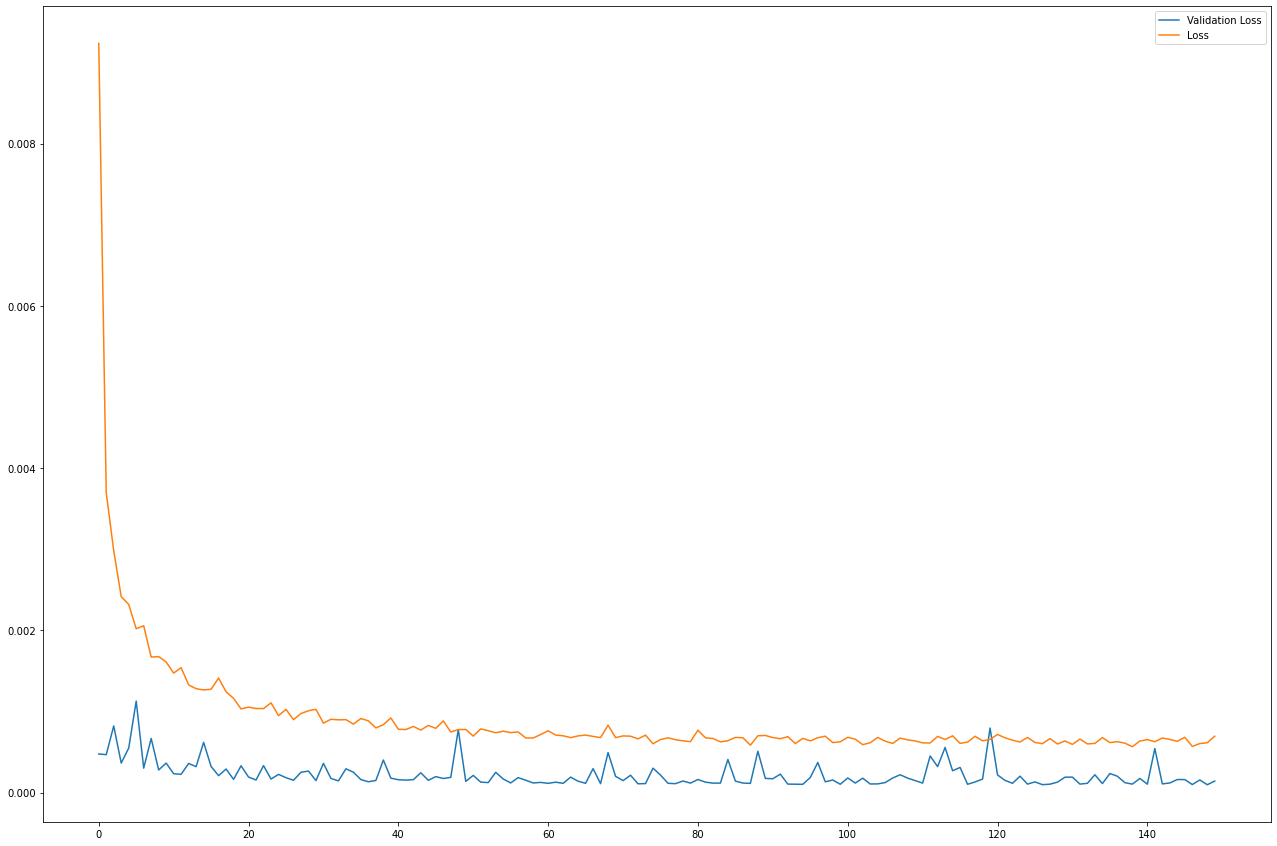

In [16]:
plt.gcf().set_size_inches(22, 15, forward=True)
validation_loss = plt.plot(history.history['val_loss'], label='Validation Loss')
loss = plt.plot(history.history['loss'], label='Loss')
plt.legend(['Validation Loss', 'Loss'])

plt.show()


In [17]:
y_test_predicted = model.predict(X_test)
# model.predict returns normalised values
# now we scale them back up using the y_scaler from before
y_test_predicted = y_normalizer.inverse_transform(y_test_predicted)

# also getting predictions for the entire dataset, just to see how it performs
y_predicted = model.predict(x_data_norm)
#not sure if the above line bias's the model towards the training data making it more accurate but it could
#since the model would have seen it before
y_predicted = y_normalizer.inverse_transform(y_predicted)

# assert y_test_unscaled.shape == y_test_predicted.shape

#real_mse = np.mean(np.square(y_test_unscaled - y_test_predicted))
#scaled_mse = real_mse / (np.max(y_test_unscaled) - np.min(y_test_unscaled)) * 100
#print(scaled_mse)


    

In [18]:
sum_error = 0
for i in range(len(y_test_predicted)):
    difference = np.array(abs(y_test_predicted[i] - y_test_unscaled[i]))
    error = np.array(difference/y_test_predicted[i])
    sum_error = sum_error + error
    divisor = i
av_error = sum_error/i
av_per_error = av_error * 100
print(av_per_error)

[1.89473272]


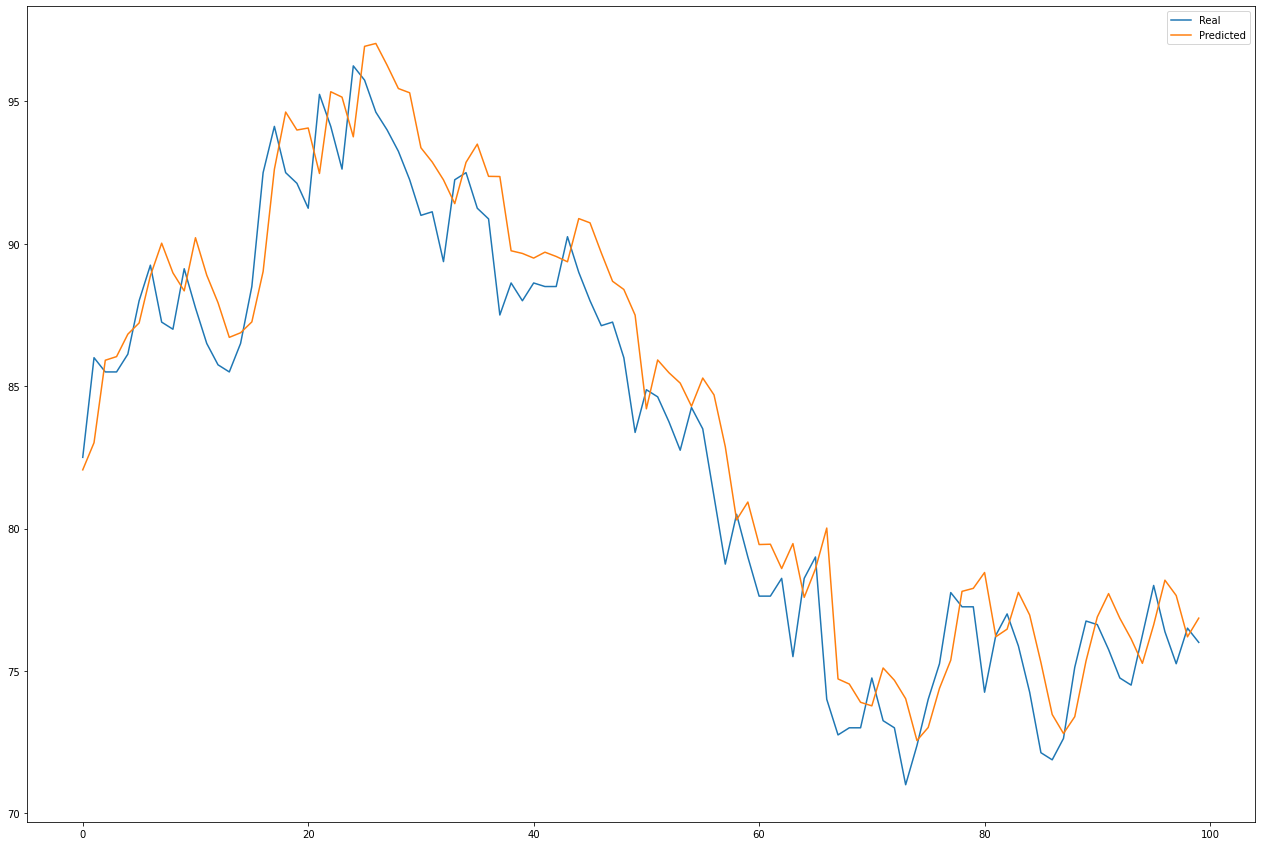

In [19]:
plt.gcf().set_size_inches(22, 15, forward=True)



real = plt.plot(y_test_unscaled[0:100], label='real')
pred = plt.plot(y_test_predicted[0:100], label='pred')
plt.legend(['Real', 'Predicted'])

plt.show()

In [20]:
# Now we start the process of gathering data to test the accuracy of the model with current data
# for this we will try and use alpha vantage. The issue is that with AV, some of the data that we used to train the
# model is not accessible.


# Solution one: We could train the model on data that is available at this stage. This could still allow for more 
# customization but we would need continuous access to the AV API and could be unrealistic in implementation. 
# Additionally, this would basically be straight 

# Solution two: we keep the data that we have and write functions to generate and create all the data for us. 
# This solution is much more robust and allows for much more customization by the user. However this would bu much more 
# time consuming. It also allows us to have a larger distinction between our algorithm and the user who created the one 
# that I tested




In [ ]:
import alpha_vantage
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators
import time

In [ ]:
ti = TechIndicators(key='TTO0UHABS6LS3FHZ', output_format='pandas')
ts = TimeSeries(key='TTO0UHABS6LS3FHZ',output_format='pandas')


In [ ]:
def get_ema_data(ema_days,time_of_price,points,symbol):
    ema_data, meta_data = ti.get_ema(symbol=symbol, interval='daily', time_period=ema_days, series_type=time_of_price)
    ema_data = ema_data.reset_index(drop=True)
    last_index = ema_data.index[-1]
    section = last_index-points
    slice_of_ema = ema_data.iloc[section:,:]
    slice_of_ema = slice_of_ema.reset_index(drop=True)

    return slice_of_ema

In [ ]:
def get_sma_data(sma_days,time_of_price,points,symbol):
    sma_data, meta_data = ti.get_sma(symbol=symbol, interval='daily', time_period=sma_days, series_type=time_of_price)
    sma_data = sma_data.reset_index(drop=True)
    last_index = sma_data.index[-1]
    section = last_index-points+1
    slice_of_sma = sma_data.iloc[section:,:]
    
    slice_of_sma = slice_of_sma.reset_index(drop=True)
    return slice_of_sma

In [ ]:
def get_macd_data(time_of_price,points,symbol):
    macd_data, meta_data = ti.get_macd(symbol='MSFT', interval='daily', series_type=time_of_price)
    macd_data = macd_data.reset_index(drop=True)
    last_index = macd_data.index[-1]
    section = last_index-points+1
    slice_of_macd = macd_data.iloc[section:,:]
    slice_of_macd = slice_of_macd.rename(columns={"MACD_Signal":"MACD Signal", "MACD_Hist":"MACD difference","MACD": "MACD Line"}) 
    macd = slice_of_macd['MACD Line']
    macd_signal = slice_of_macd['MACD Signal']
    macd_difference = slice_of_macd['MACD difference']
    
    macd = macd.reset_index(drop=True)
    macd_signal = macd_signal.reset_index(drop=True)
    macd_difference = macd_difference.reset_index(drop=True)
    
    return macd,macd_signal,macd_difference  

In [ ]:
def get_highs_lows_nextclose(symbol,points):
    
    data, meta_data = ts.get_daily(symbol)
    data = data.drop('1. open', axis = 1)
    data = data.reset_index(drop=True)
    data = data.rename(columns={"2. high":"High","3. low":"Low","4. close":"close","5. volume": "Volume"})
    
    length = data.index[-1]
    section = length-points+1
    
    high = data.iloc[section:,:1]
    low = data.iloc[section:,1:2]
    vol = data.iloc[section:,3:4]
    close = data.iloc[section:,2:3]

    high =high.reset_index(drop=True)
    low = low.reset_index(drop=True)
    vol = vol.reset_index(drop=True)
    close = close.reset_index(drop=True)
    return high,low,vol,close

In [ ]:
def get_all_data(symbol,points,time_of_price,sma_days,ema_days):
    ema_first = get_ema_data(ema_days[0],time_of_price,points,symbol)
    ema_second = get_ema_data(ema_days[1],time_of_price,points,symbol)
    ema_third = get_ema_data(ema_days[2],time_of_price,points,symbol)
    
    
    
    sma_first = get_sma_data(sma_days[0],time_of_price,points,symbol)
    sma_second = get_sma_data(sma_days[1],time_of_price,points,symbol)
    
    time.sleep(60) #add delay so that we don't trigger API warning
    
    sma_third = get_sma_data(sma_days[2],time_of_price,points,symbol)
    macd,macd_signal,macd_difference = get_macd_data(time_of_price,points,symbol)
    
    
    high,low,vol,close = get_highs_lows_nextclose(symbol,points)
    
    final_dataframe = pd.concat([close,vol,sma_first,sma_second,sma_third,ema_first,ema_second,ema_third,macd,macd_signal,macd_difference,low,high],axis=1,sort=False)
    final_dataframe = final_dataframe.drop(final_dataframe.index[-1])
    return final_dataframe

In [ ]:
input_data = get_all_data('MSFT',points,'close',sma_days,ema_days)

In [ ]:
input_data